In [214]:
import os

In [215]:
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor, TabularDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [216]:
root = os.getcwd()

## Load and process data

In [217]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
targets_a = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
targets_b = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
targets_c = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
train_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
train_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
train_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))
training = [train_a, train_b, train_c]

# validation data
validation_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
validation_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
validation_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))
validation = [validation_a, validation_b, validation_c]

# test data
test_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
test_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
test_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))
test = [test_a, test_b, test_c]

In [218]:
def add_date_features(X):
    X['hour_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['month_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.month / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.month / 12)
    
    return X

In [219]:
dataframes = [train_a, train_b, train_c, test_a, test_b, test_c, validation_a, validation_b, validation_c]

for df in dataframes:
    add_date_features(df)

In [220]:
def cleaning_val_test(val_test):
    remove = ['date_calc']
    for df in val_test:
        df['is_prediction'] = 1
        df.drop(columns=remove, inplace=True)
        
cleaning_val_test(validation)
cleaning_val_test(test)

for df in training:
    df['is_prediction'] = 0

In [221]:
trainval_a = pd.concat([train_a, validation_a], ignore_index=True)
trainval_b = pd.concat([train_b, validation_b], ignore_index=True)
trainval_c = pd.concat([train_c, validation_c], ignore_index=True)

In [222]:
trainvalA = trainval_a.set_index('date_forecast')
trainvalB = trainval_b.set_index('date_forecast')
trainvalC = trainval_c.set_index('date_forecast')

trainval = [trainvalA, trainvalB, trainvalC]

In [223]:
def resample_and_clean(dataset, time_freq='H', set_index=None):
    if set_index:
        dataset = dataset.set_index(set_index)
    return dataset.resample(time_freq).mean().dropna(how='all')

In [224]:
hourly_train_data = [resample_and_clean(ds) for ds in trainval]
hourly_test_data = [resample_and_clean(ds, set_index='date_forecast') for ds in test]

In [225]:
def shift_columns(datasets, cols_to_shift):
    for dataset in datasets:
        for col in cols_to_shift:
            new_col = f"{col}_forward"
            dataset[new_col] = dataset[col].shift(-1)
            if len(dataset) > 1:
                dataset.loc[dataset.index[-1], new_col] = dataset.loc[dataset.index[-2], col]

In [226]:
cols_to_shift = ['diffuse_rad_1h:J', 'direct_rad_1h:J', 'clear_sky_energy_1h:J']
shift_columns(hourly_train_data + hourly_test_data, cols_to_shift)

In [227]:
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index('time')
targets_c = targets_c.set_index('time')

targets = [targets_a, targets_b, targets_c]

combined_datasets = []
for X_train, y_train in zip(hourly_train_data, targets):
    train_data = X_train.join(y_train, how='inner')
    combined_datasets.append(train_data)

In [228]:
def process_dataset(train_data, target='pv_measurement', is_day_col='is_day:idx'):
    train_data['group_id'] = train_data[target].ne(train_data[target].shift()).cumsum()
    train_data['count'] = train_data.groupby('group_id')[target].transform('size')
    train_data['mask_drop'] = ((train_data['count'] > 4) & (train_data[target] > 0)) | \
                              ((train_data.groupby('group_id')[is_day_col].transform('size') > 6) & \
                               (train_data[is_day_col]) & (train_data[target] == 0))

    train_data.drop(columns=['group_id', 'count'], inplace=True)

    train_data.loc[train_data['mask_drop'], target] = np.nan
    train_data.dropna(subset=[target], inplace=True)

    train_data.drop(columns=['mask_drop'], inplace=True)

    return train_data

combined_datasets = [process_dataset(train_data) for train_data in combined_datasets]


In [229]:
def clean_features(df):
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('/', '_').replace('(', '').replace(')', '') for col in df.columns]
    return df

In [230]:
def prepare_and_split_data(train_data, test_data, target):
    X_test = clean_features(test_data)
    
    train_data_clean = clean_features(train_data)
    
    predicted_subset = train_data_clean[train_data_clean['is_prediction'] == 1]
    historical_subset = train_data_clean[train_data_clean['is_prediction'] != 1]

    forecasted_train, forecasted_tuning = train_test_split(
        predicted_subset, test_size=0.5, random_state=1)

    X_train = pd.concat([historical_subset, forecasted_train])
    
    y_train = X_train.pop(target)
    y_tuning = forecasted_tuning.pop(target)
    
    X_tuning = forecasted_tuning
    
    return X_train, y_train, X_tuning, y_tuning, X_test


## Train and predict using Autogluon

In [231]:
time_limit = 13800
target = 'pv_measurement'
threshold = 8
submission_path = 'Submissions/AutoGluon_200_5.csv'

prediction_results = []

In [232]:
def train_and_predict(X_train, y_train, X_tuning, y_tuning, X_test, target, time_limit):
    predictor = TabularPredictor(label=target, problem_type='regression', eval_metric='mae')
    predictor.fit(
        train_data=TabularDataset(X_train.assign(**{target: y_train})),
        tuning_data=TabularDataset(X_tuning.assign(**{target: y_tuning})),
        time_limit=time_limit,
        use_bag_holdout=True,
        num_bag_folds=8,
        presets='best_quality',
        num_stack_levels=0
    )
    return predictor.predict(TabularDataset(X_test))

In [240]:
for train_dataset, test_dataset in zip(combined_datasets, hourly_test_data):
    print(len(train_dataset))

33752
27231
23378


In [233]:
for train_dataset, test_dataset in zip(combined_datasets, hourly_test_data):
    X_train, y_train, X_tuning, y_tuning, X_test = prepare_and_split_data(train_dataset, test_dataset, target)
    y_pred = train_and_predict(X_train, y_train, X_tuning, y_tuning, X_test, target, time_limit)
    prediction_results.append(pd.DataFrame({'prediction': y_pred}))

No path specified. Models will be saved in: "AutogluonModels/ag-20231109_213719"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 13800s
AutoGluon will save models to "AutogluonModels/ag-20231109_213719"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
Disk Space Avail:   325.81 GB / 494.38 GB (65.9%)
Train Data Rows:    31574
Train Data Columns: 53
Tuning Data Rows:    2178
Tuning Data Columns: 53
Label Column: pv_measurement
Preprocessing data ...
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

[1000]	valid_set's l1: 161.032
[2000]	valid_set's l1: 156.873
[3000]	valid_set's l1: 154.531
[4000]	valid_set's l1: 153.071
[5000]	valid_set's l1: 152.185
[6000]	valid_set's l1: 151.194
[7000]	valid_set's l1: 150.694
[8000]	valid_set's l1: 150.289
[9000]	valid_set's l1: 149.86
[10000]	valid_set's l1: 149.549
[1000]	valid_set's l1: 176.542
[2000]	valid_set's l1: 170.516
[3000]	valid_set's l1: 167.106
[4000]	valid_set's l1: 165.054
[5000]	valid_set's l1: 163.885
[6000]	valid_set's l1: 162.889
[7000]	valid_set's l1: 162.349
[8000]	valid_set's l1: 162.049
[9000]	valid_set's l1: 161.621
[10000]	valid_set's l1: 161.175
[1000]	valid_set's l1: 173.871
[2000]	valid_set's l1: 168.28
[3000]	valid_set's l1: 165.6
[4000]	valid_set's l1: 163.994
[5000]	valid_set's l1: 162.973
[6000]	valid_set's l1: 162.386
[7000]	valid_set's l1: 161.922
[8000]	valid_set's l1: 161.682
[9000]	valid_set's l1: 161.198
[10000]	valid_set's l1: 160.927
[1000]	valid_set's l1: 173.492
[2000]	valid_set's l1: 166.097
[3000]	va

	-85.9623	 = Validation score   (-mean_absolute_error)
	260.91s	 = Training   runtime
	4.69s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 13526.6s of the 13526.6s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 161.17
[2000]	valid_set's l1: 158.732
[3000]	valid_set's l1: 158.06
[4000]	valid_set's l1: 157.646
[5000]	valid_set's l1: 157.383
[6000]	valid_set's l1: 157.305
[7000]	valid_set's l1: 157.225
[8000]	valid_set's l1: 157.232
[9000]	valid_set's l1: 157.182
[10000]	valid_set's l1: 157.162
[1000]	valid_set's l1: 175.218
[2000]	valid_set's l1: 172.514
[3000]	valid_set's l1: 171.822
[4000]	valid_set's l1: 171.413
[5000]	valid_set's l1: 171.177
[6000]	valid_set's l1: 171.078
[7000]	valid_set's l1: 171.019
[8000]	valid_set's l1: 170.965
[9000]	valid_set's l1: 170.95
[10000]	valid_set's l1: 170.922
[1000]	valid_set's l1: 173.704
[2000]	valid_set's l1: 172.101
[3000]	valid_set's l1: 171.568
[4000]	valid_set's l1: 171.017
[5000]	valid_set's l1: 170.787
[6000]	valid_set's l1: 170.532
[7000]	valid_set's l1: 170.438
[8000]	valid_set's l1: 170.402
[9000]	valid_set's l1: 170.348
[10000]	valid_set's l1: 170.317
[1000]	valid_set's l1: 172.424
[2000]	valid_set's l1: 169.163
[3000]	v

	-92.7147	 = Validation score   (-mean_absolute_error)
	300.22s	 = Training   runtime
	5.45s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13214.18s of the 13214.17s of remaining time.
	-106.6247	 = Validation score   (-mean_absolute_error)
	46.82s	 = Training   runtime
	0.75s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13166.25s of the 13166.25s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-97.0338	 = Validation score   (-mean_absolute_error)
	685.39s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 12480.59s of the 12480.59s of remaining time.
	-106.5836	 = Validation score   (-mean_absolute_error)
	7.21s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 12472.29s of the 12472.29s of remaining time.
	Fitting 8 

[1000]	valid_set's l1: 156.113
[2000]	valid_set's l1: 154.827
[3000]	valid_set's l1: 154.496
[4000]	valid_set's l1: 154.377
[5000]	valid_set's l1: 154.345
[6000]	valid_set's l1: 154.331
[7000]	valid_set's l1: 154.326
[8000]	valid_set's l1: 154.323
[9000]	valid_set's l1: 154.322
[10000]	valid_set's l1: 154.321
[1000]	valid_set's l1: 171.883
[2000]	valid_set's l1: 170.372
[3000]	valid_set's l1: 170.043
[4000]	valid_set's l1: 169.951
[5000]	valid_set's l1: 169.927
[6000]	valid_set's l1: 169.916
[7000]	valid_set's l1: 169.913
[8000]	valid_set's l1: 169.91
[9000]	valid_set's l1: 169.909
[10000]	valid_set's l1: 169.909
[1000]	valid_set's l1: 167.1
[2000]	valid_set's l1: 165.889
[3000]	valid_set's l1: 165.602
[4000]	valid_set's l1: 165.497
[5000]	valid_set's l1: 165.464
[6000]	valid_set's l1: 165.443
[7000]	valid_set's l1: 165.437
[8000]	valid_set's l1: 165.434
[9000]	valid_set's l1: 165.433
[10000]	valid_set's l1: 165.432
[1000]	valid_set's l1: 166.995
[2000]	valid_set's l1: 165.529
[3000]	v

	-92.1701	 = Validation score   (-mean_absolute_error)
	914.95s	 = Training   runtime
	10.91s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 10488.99s of the 10488.99s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 172.564
[2000]	valid_set's l1: 166.055
[3000]	valid_set's l1: 162.753
[4000]	valid_set's l1: 160.216
[5000]	valid_set's l1: 158.694
[6000]	valid_set's l1: 157.709
[7000]	valid_set's l1: 156.772
[8000]	valid_set's l1: 156.227
[9000]	valid_set's l1: 155.881
[10000]	valid_set's l1: 155.609
[1000]	valid_set's l1: 180.913
[2000]	valid_set's l1: 173.767
[3000]	valid_set's l1: 169.567
[4000]	valid_set's l1: 167.416
[5000]	valid_set's l1: 166.155
[6000]	valid_set's l1: 165.427
[7000]	valid_set's l1: 164.72
[8000]	valid_set's l1: 164.252
[9000]	valid_set's l1: 163.894
[10000]	valid_set's l1: 163.579
[1000]	valid_set's l1: 165.156
[2000]	valid_set's l1: 160.632
[3000]	valid_set's l1: 158.819
[4000]	valid_set's l1: 157.608
[5000]	valid_set's l1: 156.685
[6000]	valid_set's l1: 156.141
[7000]	valid_set's l1: 155.869
[8000]	valid_set's l1: 155.489
[9000]	valid_set's l1: 155.215
[10000]	valid_set's l1: 154.977
[1000]	valid_set's l1: 164.792
[2000]	valid_set's l1: 159.493
[3000]

	-85.5819	 = Validation score   (-mean_absolute_error)
	505.67s	 = Training   runtime
	9.7s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 10229.93s of the 10229.93s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 173.539
[2000]	valid_set's l1: 169.732
[3000]	valid_set's l1: 168.401
[4000]	valid_set's l1: 167.761
[5000]	valid_set's l1: 167.349
[6000]	valid_set's l1: 167.048
[7000]	valid_set's l1: 166.851
[8000]	valid_set's l1: 166.796
[9000]	valid_set's l1: 166.755
[10000]	valid_set's l1: 166.752
[1000]	valid_set's l1: 182.404
[2000]	valid_set's l1: 178.511
[3000]	valid_set's l1: 177.51
[4000]	valid_set's l1: 177.021
[5000]	valid_set's l1: 176.734
[6000]	valid_set's l1: 176.648
[7000]	valid_set's l1: 176.635
[8000]	valid_set's l1: 176.615
[9000]	valid_set's l1: 176.604
[10000]	valid_set's l1: 176.579
[1000]	valid_set's l1: 169.142
[2000]	valid_set's l1: 167.499
[3000]	valid_set's l1: 167.07
[4000]	valid_set's l1: 166.933
[5000]	valid_set's l1: 166.967
[1000]	valid_set's l1: 163.236
[2000]	valid_set's l1: 160.859
[3000]	valid_set's l1: 160.21
[4000]	valid_set's l1: 160.135
[5000]	valid_set's l1: 159.671
[6000]	valid_set's l1: 159.429
[7000]	valid_set's l1: 159.319
[8000]	va

	-92.5427	 = Validation score   (-mean_absolute_error)
	528.53s	 = Training   runtime
	9.96s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 9988.43s of the 9988.43s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-97.256	 = Validation score   (-mean_absolute_error)
	1293.51s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 9379.97s of the 9379.97s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df

[1000]	valid_set's l1: 165.842
[2000]	valid_set's l1: 164.398
[3000]	valid_set's l1: 164.163
[4000]	valid_set's l1: 164.067
[5000]	valid_set's l1: 164.041
[6000]	valid_set's l1: 164.024
[7000]	valid_set's l1: 164.02
[8000]	valid_set's l1: 164.018
[9000]	valid_set's l1: 164.018
[10000]	valid_set's l1: 164.017
[1000]	valid_set's l1: 176.297
[2000]	valid_set's l1: 174.624
[3000]	valid_set's l1: 174.309
[4000]	valid_set's l1: 174.216
[5000]	valid_set's l1: 174.178
[6000]	valid_set's l1: 174.16
[7000]	valid_set's l1: 174.154
[8000]	valid_set's l1: 174.151
[9000]	valid_set's l1: 174.15
[10000]	valid_set's l1: 174.149
[1000]	valid_set's l1: 161.059
[2000]	valid_set's l1: 159.698
[3000]	valid_set's l1: 159.456
[4000]	valid_set's l1: 159.383
[5000]	valid_set's l1: 159.353
[6000]	valid_set's l1: 159.337
[7000]	valid_set's l1: 159.331
[8000]	valid_set's l1: 159.329
[9000]	valid_set's l1: 159.328
[10000]	valid_set's l1: 159.327
[1000]	valid_set's l1: 157.702
[2000]	valid_set's l1: 156.32
[3000]	va

	-91.8079	 = Validation score   (-mean_absolute_error)
	1802.3s	 = Training   runtime
	22.35s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 7299.18s of the 7299.18s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 165.99
[2000]	valid_set's l1: 159.174
[3000]	valid_set's l1: 155.875
[4000]	valid_set's l1: 153.944
[5000]	valid_set's l1: 152.618
[6000]	valid_set's l1: 151.625
[7000]	valid_set's l1: 150.997
[8000]	valid_set's l1: 150.469
[9000]	valid_set's l1: 150.073
[10000]	valid_set's l1: 149.864
[1000]	valid_set's l1: 175.522
[2000]	valid_set's l1: 169.207
[3000]	valid_set's l1: 166.182
[4000]	valid_set's l1: 164.831
[5000]	valid_set's l1: 163.682
[6000]	valid_set's l1: 162.841
[7000]	valid_set's l1: 162.255
[8000]	valid_set's l1: 161.703
[9000]	valid_set's l1: 161.289
[10000]	valid_set's l1: 161.077
[1000]	valid_set's l1: 166.119
[2000]	valid_set's l1: 159.341
[3000]	valid_set's l1: 156.33
[4000]	valid_set's l1: 154.535
[5000]	valid_set's l1: 153.166
[6000]	valid_set's l1: 152.205
[7000]	valid_set's l1: 151.524
[8000]	valid_set's l1: 151.094
[9000]	valid_set's l1: 150.776
[10000]	valid_set's l1: 150.58
[1000]	valid_set's l1: 172.354
[2000]	valid_set's l1: 167.023
[3000]	v

	-85.5147	 = Validation score   (-mean_absolute_error)
	745.89s	 = Training   runtime
	14.61s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 7041.57s of the 7041.57s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 167.695
[2000]	valid_set's l1: 164.911
[3000]	valid_set's l1: 164.055
[4000]	valid_set's l1: 163.744
[5000]	valid_set's l1: 163.435
[6000]	valid_set's l1: 163.209
[7000]	valid_set's l1: 163.075
[8000]	valid_set's l1: 163.029
[9000]	valid_set's l1: 162.969
[10000]	valid_set's l1: 162.943
[1000]	valid_set's l1: 175.263
[2000]	valid_set's l1: 172.779
[3000]	valid_set's l1: 171.898
[4000]	valid_set's l1: 171.479
[5000]	valid_set's l1: 171.261
[6000]	valid_set's l1: 171.152
[7000]	valid_set's l1: 171.039
[8000]	valid_set's l1: 170.964
[9000]	valid_set's l1: 170.916
[10000]	valid_set's l1: 170.913
[1000]	valid_set's l1: 164.646
[2000]	valid_set's l1: 161.835
[3000]	valid_set's l1: 160.805
[4000]	valid_set's l1: 160.4
[5000]	valid_set's l1: 160.247
[6000]	valid_set's l1: 160.136
[7000]	valid_set's l1: 160.084
[8000]	valid_set's l1: 160.065
[9000]	valid_set's l1: 160.075
[10000]	valid_set's l1: 160.035
[1000]	valid_set's l1: 171.107
[2000]	valid_set's l1: 168.122
[3000]	

	-92.4799	 = Validation score   (-mean_absolute_error)
	766.15s	 = Training   runtime
	14.9s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 6786.89s of the 6786.89s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-97.1487	 = Validation score   (-mean_absolute_error)
	1897.06s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 6182.88s of the 6182.88s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = d

[1000]	valid_set's l1: 159.52
[2000]	valid_set's l1: 157.859
[3000]	valid_set's l1: 157.591
[4000]	valid_set's l1: 157.479
[5000]	valid_set's l1: 157.448
[6000]	valid_set's l1: 157.435
[7000]	valid_set's l1: 157.43
[8000]	valid_set's l1: 157.427
[9000]	valid_set's l1: 157.426
[10000]	valid_set's l1: 157.425
[1000]	valid_set's l1: 170.407
[2000]	valid_set's l1: 168.864
[3000]	valid_set's l1: 168.602
[4000]	valid_set's l1: 168.488
[5000]	valid_set's l1: 168.454
[6000]	valid_set's l1: 168.439
[7000]	valid_set's l1: 168.434
[8000]	valid_set's l1: 168.432
[9000]	valid_set's l1: 168.431
[10000]	valid_set's l1: 168.43
[1000]	valid_set's l1: 158.378
[2000]	valid_set's l1: 157.12
[3000]	valid_set's l1: 156.86
[4000]	valid_set's l1: 156.757
[5000]	valid_set's l1: 156.72
[6000]	valid_set's l1: 156.713
[7000]	valid_set's l1: 156.707
[8000]	valid_set's l1: 156.704
[9000]	valid_set's l1: 156.703
[10000]	valid_set's l1: 156.703
[1000]	valid_set's l1: 161.494
[2000]	valid_set's l1: 160.368
[3000]	vali

	-91.7915	 = Validation score   (-mean_absolute_error)
	2701.07s	 = Training   runtime
	33.72s	 = Validation runtime
Completed 3/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1379.99s of the 4144.75s of remaining time.
	-84.7662	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 9655.41s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231109_213719")
No path specified. Models will be saved in: "AutogluonModels/ag-20231110_001820"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 13800s
AutoGluon will save models to "AutogluonModels/ag-20231110_001820"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform 

[1000]	valid_set's l1: 22.7193
[2000]	valid_set's l1: 21.6896
[3000]	valid_set's l1: 21.2675
[4000]	valid_set's l1: 21.0239
[5000]	valid_set's l1: 20.8712
[6000]	valid_set's l1: 20.7677
[7000]	valid_set's l1: 20.6933
[8000]	valid_set's l1: 20.6354
[9000]	valid_set's l1: 20.5885
[10000]	valid_set's l1: 20.5645
[1000]	valid_set's l1: 24.4063
[2000]	valid_set's l1: 23.6523
[3000]	valid_set's l1: 23.2301
[4000]	valid_set's l1: 23.0812
[5000]	valid_set's l1: 22.9275
[6000]	valid_set's l1: 22.8092
[7000]	valid_set's l1: 22.7369
[8000]	valid_set's l1: 22.6846
[9000]	valid_set's l1: 22.6382
[10000]	valid_set's l1: 22.598
[1000]	valid_set's l1: 22.2214
[2000]	valid_set's l1: 21.5488
[3000]	valid_set's l1: 21.2647
[4000]	valid_set's l1: 21.0993
[5000]	valid_set's l1: 20.9618
[6000]	valid_set's l1: 20.8772
[7000]	valid_set's l1: 20.8045
[8000]	valid_set's l1: 20.7736
[9000]	valid_set's l1: 20.7416
[10000]	valid_set's l1: 20.7057
[1000]	valid_set's l1: 24.3151
[2000]	valid_set's l1: 23.3476
[3000]

	-10.4868	 = Validation score   (-mean_absolute_error)
	233.11s	 = Training   runtime
	4.25s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 13555.36s of the 13555.36s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.6535
[2000]	valid_set's l1: 23.3153
[3000]	valid_set's l1: 23.1922
[4000]	valid_set's l1: 23.1139
[5000]	valid_set's l1: 23.0832
[6000]	valid_set's l1: 23.0611
[7000]	valid_set's l1: 23.0489
[8000]	valid_set's l1: 23.0431
[9000]	valid_set's l1: 23.04
[10000]	valid_set's l1: 23.0378
[1000]	valid_set's l1: 24.8774
[2000]	valid_set's l1: 24.4887
[3000]	valid_set's l1: 24.3497
[4000]	valid_set's l1: 24.2803
[5000]	valid_set's l1: 24.2532
[6000]	valid_set's l1: 24.2397
[7000]	valid_set's l1: 24.2293
[8000]	valid_set's l1: 24.2206
[9000]	valid_set's l1: 24.2167
[10000]	valid_set's l1: 24.2142
[1000]	valid_set's l1: 22.7205
[2000]	valid_set's l1: 22.2876
[3000]	valid_set's l1: 22.1614
[4000]	valid_set's l1: 22.1172
[5000]	valid_set's l1: 22.0989
[6000]	valid_set's l1: 22.0971
[7000]	valid_set's l1: 22.089
[8000]	valid_set's l1: 22.085
[9000]	valid_set's l1: 22.0834
[10000]	valid_set's l1: 22.0804
[1000]	valid_set's l1: 24.8939
[2000]	valid_set's l1: 24.4767
[3000]	va

	-11.3453	 = Validation score   (-mean_absolute_error)
	230.09s	 = Training   runtime
	4.3s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13315.39s of the 13315.39s of remaining time.
	-13.6666	 = Validation score   (-mean_absolute_error)
	27.71s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13286.96s of the 13286.96s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-12.068	 = Validation score   (-mean_absolute_error)
	573.99s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 12712.74s of the 12712.74s of remaining time.
	-13.3908	 = Validation score   (-mean_absolute_error)
	4.18s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 12707.81s of the 12707.81s of remaining time.
	Fitting 8 chil

[1000]	valid_set's l1: 23.0825
[2000]	valid_set's l1: 22.995
[3000]	valid_set's l1: 22.9752
[4000]	valid_set's l1: 22.9716
[5000]	valid_set's l1: 22.9699
[6000]	valid_set's l1: 22.9695
[7000]	valid_set's l1: 22.9695
[8000]	valid_set's l1: 22.9694
[9000]	valid_set's l1: 22.9694
[10000]	valid_set's l1: 22.9693
[1000]	valid_set's l1: 24.1171
[2000]	valid_set's l1: 23.9727
[3000]	valid_set's l1: 23.9527
[4000]	valid_set's l1: 23.9474
[5000]	valid_set's l1: 23.9469
[6000]	valid_set's l1: 23.9465
[7000]	valid_set's l1: 23.9462
[8000]	valid_set's l1: 23.9462
[9000]	valid_set's l1: 23.9462
[10000]	valid_set's l1: 23.9462
[1000]	valid_set's l1: 21.255
[2000]	valid_set's l1: 21.1442
[3000]	valid_set's l1: 21.122
[4000]	valid_set's l1: 21.1179
[5000]	valid_set's l1: 21.1171
[6000]	valid_set's l1: 21.1166
[7000]	valid_set's l1: 21.1164
[8000]	valid_set's l1: 21.1164
[9000]	valid_set's l1: 21.1163
[10000]	valid_set's l1: 21.1163
[1000]	valid_set's l1: 23.9208
[2000]	valid_set's l1: 23.7848
[3000]	v

	-11.3776	 = Validation score   (-mean_absolute_error)
	845.96s	 = Training   runtime
	9.23s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 10887.86s of the 10887.86s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.7737
[2000]	valid_set's l1: 23.7455
[3000]	valid_set's l1: 23.2982
[4000]	valid_set's l1: 23.0822
[5000]	valid_set's l1: 22.947
[6000]	valid_set's l1: 22.8526
[7000]	valid_set's l1: 22.7878
[8000]	valid_set's l1: 22.7282
[9000]	valid_set's l1: 22.6892
[10000]	valid_set's l1: 22.6621
[1000]	valid_set's l1: 22.2402
[2000]	valid_set's l1: 21.2708
[3000]	valid_set's l1: 20.9175
[4000]	valid_set's l1: 20.766
[5000]	valid_set's l1: 20.6285
[6000]	valid_set's l1: 20.524
[7000]	valid_set's l1: 20.4471
[8000]	valid_set's l1: 20.3763
[9000]	valid_set's l1: 20.333
[10000]	valid_set's l1: 20.284
[1000]	valid_set's l1: 21.0825
[2000]	valid_set's l1: 20.1274
[3000]	valid_set's l1: 19.7616
[4000]	valid_set's l1: 19.5667
[5000]	valid_set's l1: 19.388
[6000]	valid_set's l1: 19.2817
[7000]	valid_set's l1: 19.219
[8000]	valid_set's l1: 19.1649
[9000]	valid_set's l1: 19.1213
[10000]	valid_set's l1: 19.0929
[1000]	valid_set's l1: 24.2744
[2000]	valid_set's l1: 23.4543
[3000]	valid

	-10.4608	 = Validation score   (-mean_absolute_error)
	465.25s	 = Training   runtime
	8.41s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 10643.33s of the 10643.33s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 24.8521
[2000]	valid_set's l1: 24.5109
[3000]	valid_set's l1: 24.3634
[4000]	valid_set's l1: 24.3066
[5000]	valid_set's l1: 24.2811
[6000]	valid_set's l1: 24.2688
[7000]	valid_set's l1: 24.2599
[8000]	valid_set's l1: 24.2549
[9000]	valid_set's l1: 24.2517
[10000]	valid_set's l1: 24.2487
[1000]	valid_set's l1: 22.9382
[2000]	valid_set's l1: 22.5412
[3000]	valid_set's l1: 22.3996
[4000]	valid_set's l1: 22.3318
[5000]	valid_set's l1: 22.2932
[6000]	valid_set's l1: 22.2704
[7000]	valid_set's l1: 22.2611
[8000]	valid_set's l1: 22.2498
[9000]	valid_set's l1: 22.2439
[10000]	valid_set's l1: 22.2411
[1000]	valid_set's l1: 21.2919
[2000]	valid_set's l1: 20.936
[3000]	valid_set's l1: 20.8062
[4000]	valid_set's l1: 20.763
[5000]	valid_set's l1: 20.7182
[6000]	valid_set's l1: 20.6913
[7000]	valid_set's l1: 20.6805
[8000]	valid_set's l1: 20.6754
[9000]	valid_set's l1: 20.6712
[10000]	valid_set's l1: 20.6696
[1000]	valid_set's l1: 24.6339
[2000]	valid_set's l1: 24.2759
[3000]	

	-11.2859	 = Validation score   (-mean_absolute_error)
	458.86s	 = Training   runtime
	8.66s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 10401.68s of the 10401.68s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-11.974	 = Validation score   (-mean_absolute_error)
	1146.12s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 9829.25s of the 9829.25s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

[1000]	valid_set's l1: 24.585
[2000]	valid_set's l1: 24.442
[3000]	valid_set's l1: 24.4206
[4000]	valid_set's l1: 24.4158
[5000]	valid_set's l1: 24.4146
[6000]	valid_set's l1: 24.4139
[7000]	valid_set's l1: 24.4138
[8000]	valid_set's l1: 24.4138
[9000]	valid_set's l1: 24.4138
[10000]	valid_set's l1: 24.4138
[1000]	valid_set's l1: 22.056
[2000]	valid_set's l1: 21.9258
[3000]	valid_set's l1: 21.9018
[4000]	valid_set's l1: 21.8986
[5000]	valid_set's l1: 21.8982
[6000]	valid_set's l1: 21.8979
[7000]	valid_set's l1: 21.8977
[8000]	valid_set's l1: 21.8976
[9000]	valid_set's l1: 21.8976
[10000]	valid_set's l1: 21.8976
[1000]	valid_set's l1: 20.8564
[2000]	valid_set's l1: 20.7049
[3000]	valid_set's l1: 20.6779
[4000]	valid_set's l1: 20.6713
[5000]	valid_set's l1: 20.6701
[6000]	valid_set's l1: 20.6695
[7000]	valid_set's l1: 20.6693
[8000]	valid_set's l1: 20.6692
[9000]	valid_set's l1: 20.6692
[10000]	valid_set's l1: 20.6692
[1000]	valid_set's l1: 23.6272
[2000]	valid_set's l1: 23.5027
[3000]	v

	-11.3943	 = Validation score   (-mean_absolute_error)
	1705.05s	 = Training   runtime
	18.67s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 8007.79s of the 8007.79s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 22.7991
[2000]	valid_set's l1: 21.9144
[3000]	valid_set's l1: 21.5054
[4000]	valid_set's l1: 21.3257
[5000]	valid_set's l1: 21.2035
[6000]	valid_set's l1: 21.0976
[7000]	valid_set's l1: 21.0339
[8000]	valid_set's l1: 20.9872
[9000]	valid_set's l1: 20.9556
[10000]	valid_set's l1: 20.9319
[1000]	valid_set's l1: 21.999
[2000]	valid_set's l1: 21.1699
[3000]	valid_set's l1: 20.7458
[4000]	valid_set's l1: 20.5527
[5000]	valid_set's l1: 20.3749
[6000]	valid_set's l1: 20.2673
[7000]	valid_set's l1: 20.2025
[8000]	valid_set's l1: 20.1521
[9000]	valid_set's l1: 20.1124
[10000]	valid_set's l1: 20.0856
[1000]	valid_set's l1: 22.8776
[2000]	valid_set's l1: 21.8354
[3000]	valid_set's l1: 21.3616
[4000]	valid_set's l1: 21.1091
[5000]	valid_set's l1: 20.963
[6000]	valid_set's l1: 20.8669
[7000]	valid_set's l1: 20.8008
[8000]	valid_set's l1: 20.7561
[9000]	valid_set's l1: 20.7164
[10000]	valid_set's l1: 20.6841
[1000]	valid_set's l1: 23.4256
[2000]	valid_set's l1: 22.5068
[3000]	

	-10.4053	 = Validation score   (-mean_absolute_error)
	697.07s	 = Training   runtime
	12.58s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 7760.73s of the 7760.73s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.1741
[2000]	valid_set's l1: 22.7725
[3000]	valid_set's l1: 22.6343
[4000]	valid_set's l1: 22.5892
[5000]	valid_set's l1: 22.5528
[6000]	valid_set's l1: 22.5349
[7000]	valid_set's l1: 22.5324
[8000]	valid_set's l1: 22.5282
[9000]	valid_set's l1: 22.5262
[10000]	valid_set's l1: 22.524
[1000]	valid_set's l1: 22.5547
[2000]	valid_set's l1: 22.1461
[3000]	valid_set's l1: 22.0238
[4000]	valid_set's l1: 21.981
[5000]	valid_set's l1: 21.9664
[6000]	valid_set's l1: 21.9534
[7000]	valid_set's l1: 21.9448
[8000]	valid_set's l1: 21.9405
[9000]	valid_set's l1: 21.9393
[10000]	valid_set's l1: 21.9355
[1000]	valid_set's l1: 23.0982
[2000]	valid_set's l1: 22.6722
[3000]	valid_set's l1: 22.5462
[4000]	valid_set's l1: 22.4912
[5000]	valid_set's l1: 22.4653
[6000]	valid_set's l1: 22.4452
[7000]	valid_set's l1: 22.4389
[8000]	valid_set's l1: 22.4373
[9000]	valid_set's l1: 22.4333
[10000]	valid_set's l1: 22.4323
[1000]	valid_set's l1: 24.1318
[2000]	valid_set's l1: 23.697
[3000]	v

	-11.2997	 = Validation score   (-mean_absolute_error)
	687.66s	 = Training   runtime
	12.89s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 7516.23s of the 7516.23s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-11.9686	 = Validation score   (-mean_absolute_error)
	1721.24s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 6940.71s of the 6940.71s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

[1000]	valid_set's l1: 22.5077
[2000]	valid_set's l1: 22.3482
[3000]	valid_set's l1: 22.3282
[4000]	valid_set's l1: 22.3241
[5000]	valid_set's l1: 22.3228
[6000]	valid_set's l1: 22.3223
[7000]	valid_set's l1: 22.3222
[8000]	valid_set's l1: 22.3222
[9000]	valid_set's l1: 22.3222
[10000]	valid_set's l1: 22.3221
[1000]	valid_set's l1: 21.5213
[2000]	valid_set's l1: 21.4137
[3000]	valid_set's l1: 21.3927
[4000]	valid_set's l1: 21.3871
[5000]	valid_set's l1: 21.3859
[6000]	valid_set's l1: 21.3854
[7000]	valid_set's l1: 21.3852
[8000]	valid_set's l1: 21.3852
[9000]	valid_set's l1: 21.3851
[10000]	valid_set's l1: 21.3851
[1000]	valid_set's l1: 22.1799
[2000]	valid_set's l1: 22.0314
[3000]	valid_set's l1: 22.0074
[4000]	valid_set's l1: 22.0029
[5000]	valid_set's l1: 22.0019
[6000]	valid_set's l1: 22.0015
[7000]	valid_set's l1: 22.0014
[8000]	valid_set's l1: 22.0014
[9000]	valid_set's l1: 22.0014
[10000]	valid_set's l1: 22.0014
[1000]	valid_set's l1: 23.1908
[2000]	valid_set's l1: 23.0621
[3000

	-11.3479	 = Validation score   (-mean_absolute_error)
	2559.83s	 = Training   runtime
	27.8s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 5045.74s of the 5045.74s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.7194
[2000]	valid_set's l1: 23.0894
[3000]	valid_set's l1: 22.7048
[4000]	valid_set's l1: 22.5278
[5000]	valid_set's l1: 22.4515
[6000]	valid_set's l1: 22.3666
[7000]	valid_set's l1: 22.3352
[8000]	valid_set's l1: 22.2818
[9000]	valid_set's l1: 22.2476
[10000]	valid_set's l1: 22.2312
[1000]	valid_set's l1: 24.3761
[2000]	valid_set's l1: 23.6386
[3000]	valid_set's l1: 23.257
[4000]	valid_set's l1: 23.0335
[5000]	valid_set's l1: 22.8928
[6000]	valid_set's l1: 22.8035
[7000]	valid_set's l1: 22.7357
[8000]	valid_set's l1: 22.669
[9000]	valid_set's l1: 22.6139
[10000]	valid_set's l1: 22.5776
[1000]	valid_set's l1: 22.2546
[2000]	valid_set's l1: 21.4277
[3000]	valid_set's l1: 20.986
[4000]	valid_set's l1: 20.7788
[5000]	valid_set's l1: 20.648
[6000]	valid_set's l1: 20.5664
[7000]	valid_set's l1: 20.4944
[8000]	valid_set's l1: 20.4554
[9000]	valid_set's l1: 20.4205
[10000]	valid_set's l1: 20.3885
[1000]	valid_set's l1: 23.9915
[2000]	valid_set's l1: 22.7844
[3000]	va

	-10.3958	 = Validation score   (-mean_absolute_error)
	929.8s	 = Training   runtime
	16.87s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 4794.56s of the 4794.56s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.4777
[2000]	valid_set's l1: 23.2176
[3000]	valid_set's l1: 23.1794
[4000]	valid_set's l1: 23.1498
[5000]	valid_set's l1: 23.1303
[6000]	valid_set's l1: 23.1238
[7000]	valid_set's l1: 23.1151
[8000]	valid_set's l1: 23.1124
[9000]	valid_set's l1: 23.1101
[10000]	valid_set's l1: 23.1095
[1000]	valid_set's l1: 24.5541
[2000]	valid_set's l1: 24.3546
[3000]	valid_set's l1: 24.3021
[4000]	valid_set's l1: 24.2543
[5000]	valid_set's l1: 24.2311
[6000]	valid_set's l1: 24.2185
[7000]	valid_set's l1: 24.2097
[8000]	valid_set's l1: 24.2053
[9000]	valid_set's l1: 24.2023
[10000]	valid_set's l1: 24.2011
[1000]	valid_set's l1: 22.5935
[2000]	valid_set's l1: 22.247
[3000]	valid_set's l1: 22.1227
[4000]	valid_set's l1: 22.0868
[5000]	valid_set's l1: 22.0548
[6000]	valid_set's l1: 22.0302
[7000]	valid_set's l1: 22.0257
[8000]	valid_set's l1: 22.0249
[9000]	valid_set's l1: 22.025
[10000]	valid_set's l1: 22.0226
[1000]	valid_set's l1: 24.3332
[2000]	valid_set's l1: 23.8726
[3000]	

	-11.2903	 = Validation score   (-mean_absolute_error)
	917.37s	 = Training   runtime
	17.28s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4545.9s of the 4545.9s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
	-11.9725	 = Validation score   (-mean_absolute_error)
	2294.26s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 3972.39s of the 3972.39s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df

[1000]	valid_set's l1: 23.5378
[2000]	valid_set's l1: 23.4557
[3000]	valid_set's l1: 23.4394
[4000]	valid_set's l1: 23.4347
[5000]	valid_set's l1: 23.4333
[6000]	valid_set's l1: 23.4328
[7000]	valid_set's l1: 23.4327
[8000]	valid_set's l1: 23.4326
[9000]	valid_set's l1: 23.4326
[10000]	valid_set's l1: 23.4325
[1000]	valid_set's l1: 24.0268
[2000]	valid_set's l1: 23.9115
[3000]	valid_set's l1: 23.8906
[4000]	valid_set's l1: 23.886
[5000]	valid_set's l1: 23.8846
[6000]	valid_set's l1: 23.8844
[7000]	valid_set's l1: 23.8843
[8000]	valid_set's l1: 23.8843
[9000]	valid_set's l1: 23.8843
[10000]	valid_set's l1: 23.8842
[1000]	valid_set's l1: 21.5942
[2000]	valid_set's l1: 21.4893
[3000]	valid_set's l1: 21.4723
[4000]	valid_set's l1: 21.4671
[5000]	valid_set's l1: 21.4661
[6000]	valid_set's l1: 21.4658
[7000]	valid_set's l1: 21.4657
[8000]	valid_set's l1: 21.4656
[9000]	valid_set's l1: 21.4656
[10000]	valid_set's l1: 21.4656
[1000]	valid_set's l1: 23.6346
[2000]	valid_set's l1: 23.516
[3000]	

	-11.3234	 = Validation score   (-mean_absolute_error)
	3426.69s	 = Training   runtime
	37.91s	 = Validation runtime
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1379.99s of the 2165.1s of remaining time.
	-10.2994	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 11635.06s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231110_001820")
No path specified. Models will be saved in: "AutogluonModels/ag-20231110_033222"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 13800s
AutoGluon will save models to "AutogluonModels/ag-20231110_033222"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform 

[1000]	valid_set's l1: 18.4109
[2000]	valid_set's l1: 17.7124
[3000]	valid_set's l1: 17.3704
[4000]	valid_set's l1: 17.1884
[5000]	valid_set's l1: 17.1143
[6000]	valid_set's l1: 17.0214
[7000]	valid_set's l1: 16.986
[8000]	valid_set's l1: 16.9642
[9000]	valid_set's l1: 16.9468
[10000]	valid_set's l1: 16.9391
[1000]	valid_set's l1: 18.9564
[2000]	valid_set's l1: 18.4622
[3000]	valid_set's l1: 18.2208
[4000]	valid_set's l1: 18.1152
[5000]	valid_set's l1: 18.0064
[6000]	valid_set's l1: 17.9184
[7000]	valid_set's l1: 17.877
[8000]	valid_set's l1: 17.847
[9000]	valid_set's l1: 17.8216
[10000]	valid_set's l1: 17.8083
[1000]	valid_set's l1: 20.7043
[2000]	valid_set's l1: 19.8868
[3000]	valid_set's l1: 19.5994
[4000]	valid_set's l1: 19.4475
[5000]	valid_set's l1: 19.3271
[6000]	valid_set's l1: 19.2395
[7000]	valid_set's l1: 19.2159
[8000]	valid_set's l1: 19.1832
[9000]	valid_set's l1: 19.1516
[10000]	valid_set's l1: 19.1395
[1000]	valid_set's l1: 17.9259
[2000]	valid_set's l1: 17.4561
[3000]	v

	-11.9139	 = Validation score   (-mean_absolute_error)
	232.13s	 = Training   runtime
	3.79s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 13557.78s of the 13557.78s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 18.7414
[2000]	valid_set's l1: 18.4723
[3000]	valid_set's l1: 18.3433
[4000]	valid_set's l1: 18.3009
[5000]	valid_set's l1: 18.2787
[6000]	valid_set's l1: 18.2726
[7000]	valid_set's l1: 18.266
[8000]	valid_set's l1: 18.2621
[9000]	valid_set's l1: 18.259
[10000]	valid_set's l1: 18.2578
[1000]	valid_set's l1: 19.6106
[2000]	valid_set's l1: 19.4831
[3000]	valid_set's l1: 19.4311
[4000]	valid_set's l1: 19.4015
[5000]	valid_set's l1: 19.3868
[6000]	valid_set's l1: 19.3744
[7000]	valid_set's l1: 19.3701
[8000]	valid_set's l1: 19.3672
[9000]	valid_set's l1: 19.3656
[10000]	valid_set's l1: 19.365
[1000]	valid_set's l1: 21.347
[2000]	valid_set's l1: 21.018
[3000]	valid_set's l1: 20.9258
[4000]	valid_set's l1: 20.9282
[5000]	valid_set's l1: 20.9204
[6000]	valid_set's l1: 20.9083
[7000]	valid_set's l1: 20.9027
[8000]	valid_set's l1: 20.8978
[9000]	valid_set's l1: 20.8969
[10000]	valid_set's l1: 20.8959
[1000]	valid_set's l1: 18.4035
[2000]	valid_set's l1: 18.1413
[3000]	val

	-13.4649	 = Validation score   (-mean_absolute_error)
	241.13s	 = Training   runtime
	3.96s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 13307.56s of the 13307.56s of remaining time.
	-18.3707	 = Validation score   (-mean_absolute_error)
	21.13s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 13285.84s of the 13285.84s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-13.7655	 = Validation score   (-mean_absolute_error)
	568.26s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 12717.37s of the 12717.37s of remaining time.
	-16.2828	 = Validation score   (-mean_absolute_error)
	3.07s	 = Training   runtime
	0.43s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 12713.68s of the 12713.68s of remaining time.
	Fitting 8 ch

[1000]	valid_set's l1: 18.3112
[2000]	valid_set's l1: 18.2094
[3000]	valid_set's l1: 18.1976
[4000]	valid_set's l1: 18.1958
[5000]	valid_set's l1: 18.1954
[6000]	valid_set's l1: 18.1953
[7000]	valid_set's l1: 18.1952
[8000]	valid_set's l1: 18.1952
[9000]	valid_set's l1: 18.1952
[1000]	valid_set's l1: 19.0789
[2000]	valid_set's l1: 19.022
[3000]	valid_set's l1: 19.0138
[4000]	valid_set's l1: 19.011
[5000]	valid_set's l1: 19.0104
[6000]	valid_set's l1: 19.0102
[7000]	valid_set's l1: 19.0102
[8000]	valid_set's l1: 19.0102
[9000]	valid_set's l1: 19.0102
[10000]	valid_set's l1: 19.0102
[1000]	valid_set's l1: 21.0884
[2000]	valid_set's l1: 21.0193
[3000]	valid_set's l1: 21.0095
[4000]	valid_set's l1: 21.0078
[5000]	valid_set's l1: 21.0073
[6000]	valid_set's l1: 21.0073
[7000]	valid_set's l1: 21.0073
[8000]	valid_set's l1: 21.0073
[9000]	valid_set's l1: 21.0073
[1000]	valid_set's l1: 17.8234
[2000]	valid_set's l1: 17.7441
[3000]	valid_set's l1: 17.7329
[4000]	valid_set's l1: 17.7309
[5000]	va

	-13.6471	 = Validation score   (-mean_absolute_error)
	825.76s	 = Training   runtime
	7.45s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 11051.61s of the 11051.61s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 18.3109
[2000]	valid_set's l1: 17.5702
[3000]	valid_set's l1: 17.299
[4000]	valid_set's l1: 17.1561
[5000]	valid_set's l1: 17.0559
[6000]	valid_set's l1: 16.9801
[7000]	valid_set's l1: 16.9321
[8000]	valid_set's l1: 16.8997
[9000]	valid_set's l1: 16.86
[10000]	valid_set's l1: 16.8366
[1000]	valid_set's l1: 19.674
[2000]	valid_set's l1: 19.1387
[3000]	valid_set's l1: 18.9044
[4000]	valid_set's l1: 18.7685
[5000]	valid_set's l1: 18.6954
[6000]	valid_set's l1: 18.643
[7000]	valid_set's l1: 18.606
[8000]	valid_set's l1: 18.583
[9000]	valid_set's l1: 18.572
[10000]	valid_set's l1: 18.5501
[1000]	valid_set's l1: 21.1431
[2000]	valid_set's l1: 20.5384
[3000]	valid_set's l1: 20.2125
[4000]	valid_set's l1: 20.0494
[5000]	valid_set's l1: 19.9564
[6000]	valid_set's l1: 19.8968
[7000]	valid_set's l1: 19.836
[8000]	valid_set's l1: 19.7973
[9000]	valid_set's l1: 19.7648
[10000]	valid_set's l1: 19.7484
[1000]	valid_set's l1: 18.538
[2000]	valid_set's l1: 18.0223
[3000]	valid_se

	-11.7706	 = Validation score   (-mean_absolute_error)
	472.46s	 = Training   runtime
	7.53s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 10800.2s of the 10800.2s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.198
[2000]	valid_set's l1: 18.9408
[3000]	valid_set's l1: 18.8361
[4000]	valid_set's l1: 18.7898
[5000]	valid_set's l1: 18.7651
[6000]	valid_set's l1: 18.7479
[7000]	valid_set's l1: 18.7423
[8000]	valid_set's l1: 18.7377
[9000]	valid_set's l1: 18.7359
[10000]	valid_set's l1: 18.7349
[1000]	valid_set's l1: 20.3815
[2000]	valid_set's l1: 20.2421
[3000]	valid_set's l1: 20.1973
[4000]	valid_set's l1: 20.162
[5000]	valid_set's l1: 20.1463
[6000]	valid_set's l1: 20.1367
[7000]	valid_set's l1: 20.1314
[8000]	valid_set's l1: 20.13
[9000]	valid_set's l1: 20.1275
[10000]	valid_set's l1: 20.1268
[1000]	valid_set's l1: 21.1269
[2000]	valid_set's l1: 20.8105
[3000]	valid_set's l1: 20.6924
[4000]	valid_set's l1: 20.6411
[5000]	valid_set's l1: 20.623
[6000]	valid_set's l1: 20.6087
[7000]	valid_set's l1: 20.6013
[8000]	valid_set's l1: 20.5989
[9000]	valid_set's l1: 20.5984
[10000]	valid_set's l1: 20.5977
[1000]	valid_set's l1: 19.215
[2000]	valid_set's l1: 18.9825
[3000]	vali

	-13.4499	 = Validation score   (-mean_absolute_error)
	469.81s	 = Training   runtime
	7.81s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 10560.03s of the 10560.03s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
	-13.6913	 = Validation score   (-mean_absolute_error)
	1134.14s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 9993.86s of the 9993.86s of remaining time.
	Fitting 8 child models (S2F1 - S2F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df =

[1000]	valid_set's l1: 18.6569
[2000]	valid_set's l1: 18.5724
[3000]	valid_set's l1: 18.5609
[4000]	valid_set's l1: 18.5581
[5000]	valid_set's l1: 18.5578
[6000]	valid_set's l1: 18.5577
[7000]	valid_set's l1: 18.5576
[8000]	valid_set's l1: 18.5576
[9000]	valid_set's l1: 18.5576
[10000]	valid_set's l1: 18.5576
[1000]	valid_set's l1: 19.6012
[2000]	valid_set's l1: 19.5287
[3000]	valid_set's l1: 19.5164
[4000]	valid_set's l1: 19.5141
[5000]	valid_set's l1: 19.5134
[6000]	valid_set's l1: 19.5132
[7000]	valid_set's l1: 19.5131
[8000]	valid_set's l1: 19.5131
[9000]	valid_set's l1: 19.5131
[10000]	valid_set's l1: 19.5131
[1000]	valid_set's l1: 20.0659
[2000]	valid_set's l1: 19.9803
[3000]	valid_set's l1: 19.967
[4000]	valid_set's l1: 19.9646
[5000]	valid_set's l1: 19.964
[6000]	valid_set's l1: 19.9639
[7000]	valid_set's l1: 19.9639
[1000]	valid_set's l1: 18.281
[2000]	valid_set's l1: 18.2269
[3000]	valid_set's l1: 18.2161
[4000]	valid_set's l1: 18.2144
[5000]	valid_set's l1: 18.2139
[6000]	va

	-13.5811	 = Validation score   (-mean_absolute_error)
	1621.39s	 = Training   runtime
	14.36s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 8291.79s of the 8291.79s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.8686
[2000]	valid_set's l1: 19.1329
[3000]	valid_set's l1: 18.8345
[4000]	valid_set's l1: 18.6742
[5000]	valid_set's l1: 18.5485
[6000]	valid_set's l1: 18.4785
[7000]	valid_set's l1: 18.444
[8000]	valid_set's l1: 18.4058
[9000]	valid_set's l1: 18.383
[10000]	valid_set's l1: 18.3599
[1000]	valid_set's l1: 17.4934
[2000]	valid_set's l1: 17.1065
[3000]	valid_set's l1: 16.9175
[4000]	valid_set's l1: 16.7747
[5000]	valid_set's l1: 16.6866
[6000]	valid_set's l1: 16.6284
[7000]	valid_set's l1: 16.5805
[8000]	valid_set's l1: 16.5546
[9000]	valid_set's l1: 16.5413
[10000]	valid_set's l1: 16.5272
[1000]	valid_set's l1: 20.0868
[2000]	valid_set's l1: 19.5548
[3000]	valid_set's l1: 19.3299
[4000]	valid_set's l1: 19.1845
[5000]	valid_set's l1: 19.1174
[6000]	valid_set's l1: 19.0682
[7000]	valid_set's l1: 19.0361
[8000]	valid_set's l1: 19.0108
[9000]	valid_set's l1: 18.9864
[10000]	valid_set's l1: 18.9679
[1000]	valid_set's l1: 19.9741
[2000]	valid_set's l1: 19.3506
[3000]	

	-11.7722	 = Validation score   (-mean_absolute_error)
	703.22s	 = Training   runtime
	11.3s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 8047.22s of the 8047.22s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 20.0692
[2000]	valid_set's l1: 19.778
[3000]	valid_set's l1: 19.7082
[4000]	valid_set's l1: 19.6664
[5000]	valid_set's l1: 19.6528
[6000]	valid_set's l1: 19.645
[7000]	valid_set's l1: 19.6417
[8000]	valid_set's l1: 19.6365
[9000]	valid_set's l1: 19.6337
[10000]	valid_set's l1: 19.6314
[1000]	valid_set's l1: 17.9122
[2000]	valid_set's l1: 17.7591
[3000]	valid_set's l1: 17.6549
[4000]	valid_set's l1: 17.6248
[5000]	valid_set's l1: 17.599
[6000]	valid_set's l1: 17.5892
[7000]	valid_set's l1: 17.5838
[8000]	valid_set's l1: 17.5807
[9000]	valid_set's l1: 17.5802
[10000]	valid_set's l1: 17.5797
[1000]	valid_set's l1: 20.8285
[2000]	valid_set's l1: 20.5918
[3000]	valid_set's l1: 20.5166
[4000]	valid_set's l1: 20.4673
[5000]	valid_set's l1: 20.4443
[6000]	valid_set's l1: 20.4362
[7000]	valid_set's l1: 20.4321
[8000]	valid_set's l1: 20.4308
[9000]	valid_set's l1: 20.4278
[10000]	valid_set's l1: 20.4278
[1000]	valid_set's l1: 20.8337
[2000]	valid_set's l1: 20.5741
[3000]	v

	-13.442	 = Validation score   (-mean_absolute_error)
	699.09s	 = Training   runtime
	11.34s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 7804.52s of the 7804.52s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
	-13.6731	 = Validation score   (-mean_absolute_error)
	1700.66s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 7237.64s of the 7237.64s of remaining time.
	Fitting 8 child models (S3F1 - S3F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = d

[1000]	valid_set's l1: 19.8526
[2000]	valid_set's l1: 19.7671
[3000]	valid_set's l1: 19.7532
[4000]	valid_set's l1: 19.7501
[5000]	valid_set's l1: 19.7496
[6000]	valid_set's l1: 19.7495
[7000]	valid_set's l1: 19.7494
[8000]	valid_set's l1: 19.7494
[9000]	valid_set's l1: 19.7494
[10000]	valid_set's l1: 19.7494
[1000]	valid_set's l1: 17.1887
[2000]	valid_set's l1: 17.1147
[3000]	valid_set's l1: 17.105
[4000]	valid_set's l1: 17.1021
[5000]	valid_set's l1: 17.1019
[1000]	valid_set's l1: 20.2853
[2000]	valid_set's l1: 20.2042
[3000]	valid_set's l1: 20.1944
[4000]	valid_set's l1: 20.1927
[5000]	valid_set's l1: 20.1923
[6000]	valid_set's l1: 20.1921
[7000]	valid_set's l1: 20.1921
[8000]	valid_set's l1: 20.1921
[9000]	valid_set's l1: 20.1921
[10000]	valid_set's l1: 20.1921
[1000]	valid_set's l1: 20.1519
[2000]	valid_set's l1: 20.0852
[3000]	valid_set's l1: 20.0751
[4000]	valid_set's l1: 20.0736
[5000]	valid_set's l1: 20.073
[6000]	valid_set's l1: 20.0729
[7000]	valid_set's l1: 20.0729
[1000]	v

	-13.4763	 = Validation score   (-mean_absolute_error)
	2417.0s	 = Training   runtime
	21.0s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 5560.11s of the 5560.11s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.0126
[2000]	valid_set's l1: 18.5219
[3000]	valid_set's l1: 18.3414
[4000]	valid_set's l1: 18.2312
[5000]	valid_set's l1: 18.176
[6000]	valid_set's l1: 18.1429
[7000]	valid_set's l1: 18.1032
[8000]	valid_set's l1: 18.0707
[9000]	valid_set's l1: 18.0513
[10000]	valid_set's l1: 18.0445
[1000]	valid_set's l1: 20.4793
[2000]	valid_set's l1: 19.861
[3000]	valid_set's l1: 19.5421
[4000]	valid_set's l1: 19.3456
[5000]	valid_set's l1: 19.2353
[6000]	valid_set's l1: 19.1683
[7000]	valid_set's l1: 19.1347
[8000]	valid_set's l1: 19.117
[9000]	valid_set's l1: 19.101
[10000]	valid_set's l1: 19.0891
[1000]	valid_set's l1: 19.7719
[2000]	valid_set's l1: 19.2072
[3000]	valid_set's l1: 18.9484
[4000]	valid_set's l1: 18.8177
[5000]	valid_set's l1: 18.7159
[6000]	valid_set's l1: 18.6647
[7000]	valid_set's l1: 18.6159
[8000]	valid_set's l1: 18.5675
[9000]	valid_set's l1: 18.5508
[10000]	valid_set's l1: 18.5372
[1000]	valid_set's l1: 19.2396
[2000]	valid_set's l1: 18.5305
[3000]	va

	-11.7358	 = Validation score   (-mean_absolute_error)
	933.41s	 = Training   runtime
	15.14s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 5313.74s of the 5313.74s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 19.8155
[2000]	valid_set's l1: 19.6487
[3000]	valid_set's l1: 19.5717
[4000]	valid_set's l1: 19.5519
[5000]	valid_set's l1: 19.5467
[6000]	valid_set's l1: 19.5492
[1000]	valid_set's l1: 20.6787
[2000]	valid_set's l1: 20.5121
[3000]	valid_set's l1: 20.4339
[4000]	valid_set's l1: 20.4184
[5000]	valid_set's l1: 20.4052
[6000]	valid_set's l1: 20.3999
[7000]	valid_set's l1: 20.3929
[8000]	valid_set's l1: 20.389
[9000]	valid_set's l1: 20.3874
[10000]	valid_set's l1: 20.3876
[1000]	valid_set's l1: 20.5543
[2000]	valid_set's l1: 20.3881
[3000]	valid_set's l1: 20.304
[4000]	valid_set's l1: 20.271
[5000]	valid_set's l1: 20.2526
[6000]	valid_set's l1: 20.2447
[7000]	valid_set's l1: 20.2431
[8000]	valid_set's l1: 20.242
[9000]	valid_set's l1: 20.2408
[10000]	valid_set's l1: 20.2414
[1000]	valid_set's l1: 19.9817
[2000]	valid_set's l1: 19.7266
[1000]	valid_set's l1: 19.1098
[2000]	valid_set's l1: 18.8043
[3000]	valid_set's l1: 18.648
[4000]	valid_set's l1: 18.5934
[5000]	vali

	-13.4212	 = Validation score   (-mean_absolute_error)
	893.18s	 = Training   runtime
	14.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 5105.56s of the 5105.56s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
	-13.6568	 = Validation score   (-mean_absolute_error)
	2266.43s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 4539.34s of the 4539.34s of remaining time.
	Fitting 8 child models (S4F1 - S4F8) | Fitting with SequentialLocalFoldFittingStrategy
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = 

[1000]	valid_set's l1: 19.204
[2000]	valid_set's l1: 19.1342
[3000]	valid_set's l1: 19.1279
[4000]	valid_set's l1: 19.1271
[5000]	valid_set's l1: 19.127
[6000]	valid_set's l1: 19.1269
[7000]	valid_set's l1: 19.1269
[8000]	valid_set's l1: 19.1268
[9000]	valid_set's l1: 19.1269
[1000]	valid_set's l1: 19.9584
[2000]	valid_set's l1: 19.9064
[3000]	valid_set's l1: 19.8967
[4000]	valid_set's l1: 19.8945
[5000]	valid_set's l1: 19.894
[6000]	valid_set's l1: 19.894
[7000]	valid_set's l1: 19.8939
[8000]	valid_set's l1: 19.8939
[9000]	valid_set's l1: 19.8939
[10000]	valid_set's l1: 19.8939
[1000]	valid_set's l1: 20.1585
[2000]	valid_set's l1: 20.0792
[3000]	valid_set's l1: 20.0652
[4000]	valid_set's l1: 20.0636
[5000]	valid_set's l1: 20.0633
[6000]	valid_set's l1: 20.0633
[7000]	valid_set's l1: 20.0632
[8000]	valid_set's l1: 20.0632
[9000]	valid_set's l1: 20.0632
[10000]	valid_set's l1: 20.0632
[1000]	valid_set's l1: 19.1873
[2000]	valid_set's l1: 19.1039
[3000]	valid_set's l1: 19.0981
[4000]	val

	-13.4954	 = Validation score   (-mean_absolute_error)
	3229.86s	 = Training   runtime
	27.71s	 = Validation runtime
Completed 4/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 1379.99s of the 2934.17s of remaining time.
	-11.7271	 = Validation score   (-mean_absolute_error)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 10865.99s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231110_033222")
/Users/odagraufferntsen/miniforge3/envs/ml/lib/python3.10/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:192: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df = df.fillna(column_fills, inplace=False, do

In [234]:
final_submission = pd.concat(prediction_results, ignore_index=True)
final_submission.loc[final_submission['prediction'] < threshold, 'prediction'] = 0
final_submission.reset_index(drop=True, inplace=True)
final_submission.index.name = 'id'

final_submission.to_csv(submission_path, index=True)

## Plots for each location

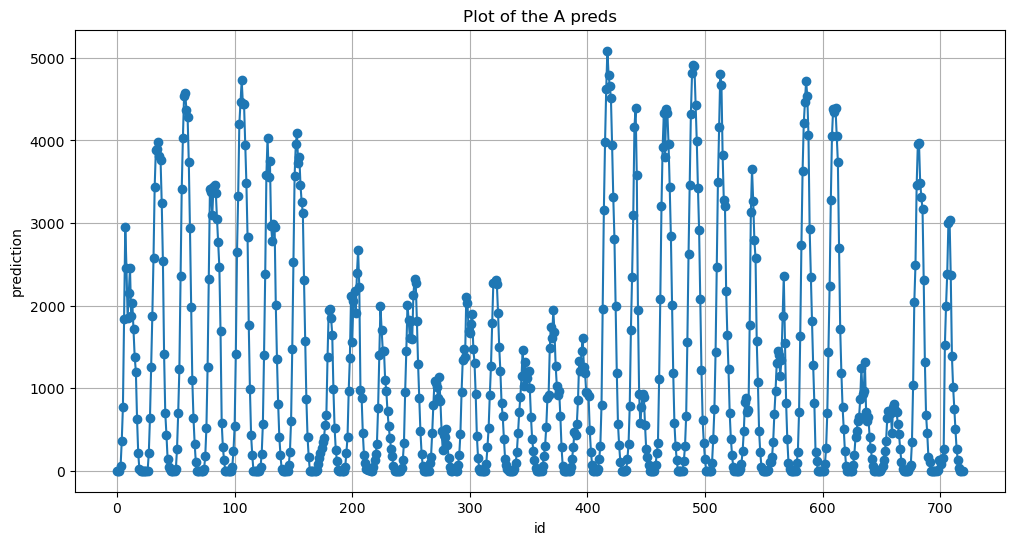

In [235]:
# Assuming 'result_df' is the DataFrame with the predictions
final_submission['id'] = final_submission.index

# Now 'first_720_rows' will also have the 'id' column
first_720_rows = final_submission.iloc[:720]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the A preds')
plt.grid(True)
plt.show()


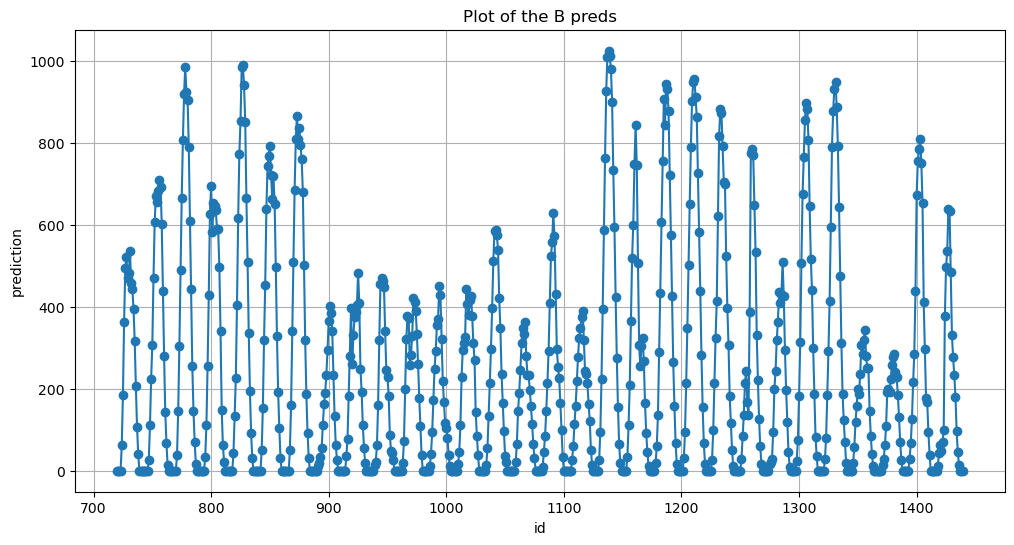

In [236]:
# Assuming you have 'result_df' containing the data
first_720_rows = final_submission.iloc[720:1440]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the B preds')
plt.grid(True)
plt.show()

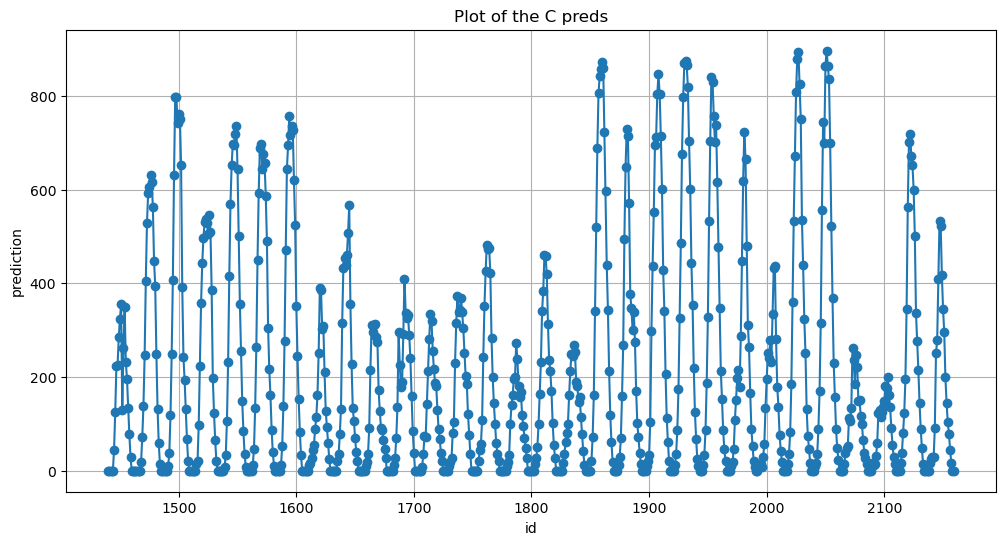

In [237]:
# Assuming you have 'result_df' containing the data
first_720_rows = final_submission.iloc[1440:]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(first_720_rows['id'], first_720_rows['prediction'], marker='o', linestyle='-')
plt.xlabel('id')
plt.ylabel('prediction')
plt.title('Plot of the C preds')
plt.grid(True)
plt.show()